## ast2vec Tutorial

This tutorial illustrates how to use ast2vec to perform some simple analyses on data from an introductory programming course. The example dataset we consider here is a synthetic mock data set of 10 students who try to solve the following programming task.

> Write a program that asks the user 'What are your favourite animals? '. If the user's response is 'Quokkas', the program should print 'Quokkas are the best!'. If the user's response is anything else, the program should print 'I agree, x are great animals.', where x is the user's response.

We simulate that the students receive feedback based on four test cases.

1. Independent of the input, we expect that the program first asks 'What are your favourite animals? '
2. If the program receives the input 'Quokkas', we expect that the program has the output 'What are your favourite animals? Quokkas are the best!'
3. If the program receives the input 'Koalas', we expect that the program has the output 'What are your favourite animals? I agree, Koalas are great animals.'
4. I fthe program receives the input 'Echidnas', we expect that the program has the output 'What are your favourite animals? I agree, Echidnas are great animals.'

The test cases are executed in order and the student receives feedback based on the first test that failed.

The reference correct solution for the task is

```python
animals = input("What are your favourite animals? ")
if animals == "Quokkas":
  print("Quokkas are the best!")
else:
  print(f"I agree, {animals} are great animals.")
```

### Loading the ast2vec model and the data

In a first step, we prepare our analyses by loading the ast2vec model and our data. For our example, the data takes the form of _traces_, i.e. sequences of code snapshots starting at the empty program and ending at a solution that passes all test cases. There is one sequence per student.

In [1]:
import os

# load the data first. We create a list of all programs and a list of traces,
# where each trace is a list of program indices
programs     = ['']
traces       = []
# start loading the data
student_dirs = list(sorted(os.listdir('mock_dataset')))
for student_dir in student_dirs:
    # initialize a new trace for the student which starts at the empty program
    trace = [0]
    # load all steps of this student
    steps = list(sorted(os.listdir(f'mock_dataset/{student_dir}')))
    for step in steps:
        # load the current program
        with open(f'mock_dataset/{student_dir}/{step}') as program_file:
            trace.append(len(programs))
            programs.append(program_file.read())
    # append the trace
    traces.append(trace)
print('read %d traces with %d programs' % (len(traces), len(programs)))

read 10 traces with 58 programs


The `python_ast_utils.parse_asts` function takes an array of programs (as source code strings) as input and returns a syntax tree for each program in node list/adjacency list format. In more detail, the API is as follows.

*Parameters*
* srcs: list
        A list of Python source code strings.
* filter_uniques: bool (default = False)
        If set to True, the output list may be shorter than the srcs input
        list because only unique trees are kept.
* ids: list (default = None)
        A list of hashable ids for every source code string.
* ignore_syntax_errors: bool (default = False)
        If set to true, non-compiling programs will be ignored.
* verbose: bool (default = False)
        If set to true, a progress bar is printed using tqdm.

*Returns*
* trees: list
        A list of triples, each of which contains a node list as first,
        an adjacency list as second, and a dictionary of variable names
        mapped to node indices as third argument. Note that this list may
        be shorter than the input source code list if filter_uniques is
        set to True.
* id_map: dict
        A dictionary of indices in the src list to indices in the trees
        list OR a dictionary of ids to indices in the tree list, if
        ids is not None. This second output is only returned if
        filter_uniques is set to True.

In [2]:
# compile the student code into syntax trees and keep track which programs map to the same
# syntax tree
import python_ast_utils

trees, programs_to_trees = python_ast_utils.parse_asts(programs, filter_uniques = True)
print('After compilation, %d unique syntax trees were left' % len(trees))

After compilation, 25 unique syntax trees were left


In [3]:
# check how often each tree occured in the data
import numpy as np
histogram = np.zeros(len(trees))
for i in programs_to_trees:
    j = programs_to_trees[i]
    histogram[j] += 1

In [4]:
# now we load the ast2vec model
import ast2vec

model = ast2vec.load_model('ast2vec.pt')

In [5]:
# and encode all the syntax trees as points
X = ast2vec.encode_trees(model, trees)

### An example syntax tree

An important first thing to understand about syntax trees is that, even for a few lines of code, they can get surprisingly large. Consider the aforementioned correct solution

```python
animals = input("What are your favourite animals? ")
if animals == "Quokkas":
  print("Quokkas are the best!")
else:
  print(f"I agree, {animals} are great animals.")
```

The syntax tree even for this simple, 5-line program has already 25 nodes and looks like this.

In [6]:
import tree

# get the index of the program, which is the last program in the first trace
program_index = traces[0][-1]
# get the corresponding syntax tree index
tree_index    = programs_to_trees[program_index]
# retrieve the actual syntax tree in node list/adjacency list format
nodes = trees[tree_index][0]
adj   = trees[tree_index][1]
# print the syntax tree
print('the tree has %d nodes' % len(nodes))
print(tree.tree_to_string(nodes, adj, indent = True))

the tree has 25 nodes
Module(
	Assign(
		Name,
		Call(
			Name,
			Str
		)
	),
	If(
		Compare(
			Name,
			Eq,
			Str
		),
		Then(
			Expr(
				Call(
					Name,
					Str
				)
			)
		),
		Else(
			Expr(
				Call(
					Name,
					JoinedStr(
						Str,
						FormattedValue(
							Name
						),
						Str
					)
				)
			)
		)
	)
)


### The issue with functions and variables

One issue with the ast2vec model is that, during decoding, it only recovers the syntax tree as above. In such a syntax tree, we know that a function is called, but not which one. We know that a variable was references, but not which one. This additional information needs to be recovered in some other form. We provide a variable classifier for this purpose which takes the encodings derived by the ast2vec model and 'guesses' the function and variable reference from example data.

In [7]:
import variable_classifier
# initialize a variable classifier
vc = variable_classifier.VariableClassifier(model)
# fit it to our example dataset
vc.fit(trees);

### Visualizing the latent space

The first thing we can do is to just inspect the latent space between the empty program and the correct solution mentioned above.

The precise documentation of the interpolation_plot function is as follows:

Does an interpolation plot, i.e. plots a grid between the start and the end tree, coloring the grid according to the tree the grid point decodes to. 

If the optional X argument is given, this is a 2D grid, otherwise it is only 1D.

The plot_code most common trees are printed into the plot.

*Parameters*
* model: class recursive_tree_grammar_auto_encoder.TreeGrammarAutoEncoder
        An instance of the ast2vec model.
* start_tree: tuple OR int
        The tree where we start the interpolation, represented as a tuple of
        node list and adjacency list. If the X argument is given, this can also
        be just the index of the start data point.
* target_tree: tuple OR int
        The tree where we end the interpolation, represented as a tuple of
        node list and adjacency list. If the X argument is given, this can also
        be just the index of the target data point.
* grid_size: int (default = 11)
        The number of regular samples between start and target.
* X: ndarray of size m x 256 (default = None)
        A matrix of reference encodings
* max_size: int (default = 100)
        A maximum tree size for decoding to prevent endless loops.
* variable_classifier: class variable_classifier.VariableClassifier (default = None)
        An optional variable classifier to make the printed code more
        clear.
* plot_code: int (default = 3)
        The source code corresponding to the most frequent plot_code trees in
        the grid is included in the plot.

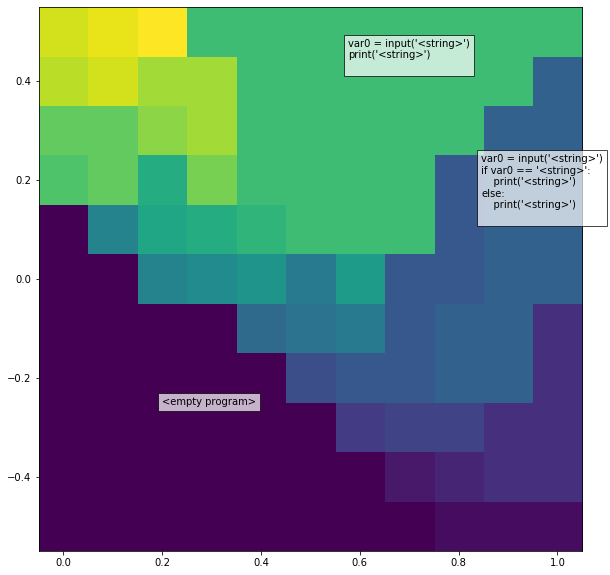

In [8]:
# perform a linear interpolation on a grid between empty program and correct solution

import matplotlib.pyplot as plt
plt.figure(figsize = (15, 10))
ast2vec.interpolation_plot(model, start_tree = 0, target_tree = tree_index, X = X, variable_classifier = vc)

What we can also do is to provide a visualization of the general student movement via a quiver plot, at least for small datasets like this one. We use the same 2D representation as in the plot above but now plot arrows indicating student motion. The point color indicates how often a point was visited, the arrow color distinguishes different students.

The detailed documentation of the traces_plot function is as follows.

*Parameters*

* start: int
        The index of the start tree for all students.
* target: int
        The inex of the target tree for all students, e.g. the index of the
        most popular correct solution.
* traces: list
        A list of student traces in terms of indices, i.e. a list of lists,
        where each entry is the index of a tree.
* X: ndarray of size m x 256
        The data matrix such that X[start, :] is the point representation
        of the initial student state, X[target, :] represents the correct
        solution, and X[traces[i][t], :] represents the t-th step of the i-th
        student trace in the data.
* trees: list (default = None)
        A list of trees as triples of node list, adjacency list, and variable
        maps from the student data. This is necessary to draw example student
        code. Otherwise, only the arrows are drawn.
* plot_code: int (default = 0)
        The source code corresponding to the most frequent plot_code trees in
        the grid is included in the plot.


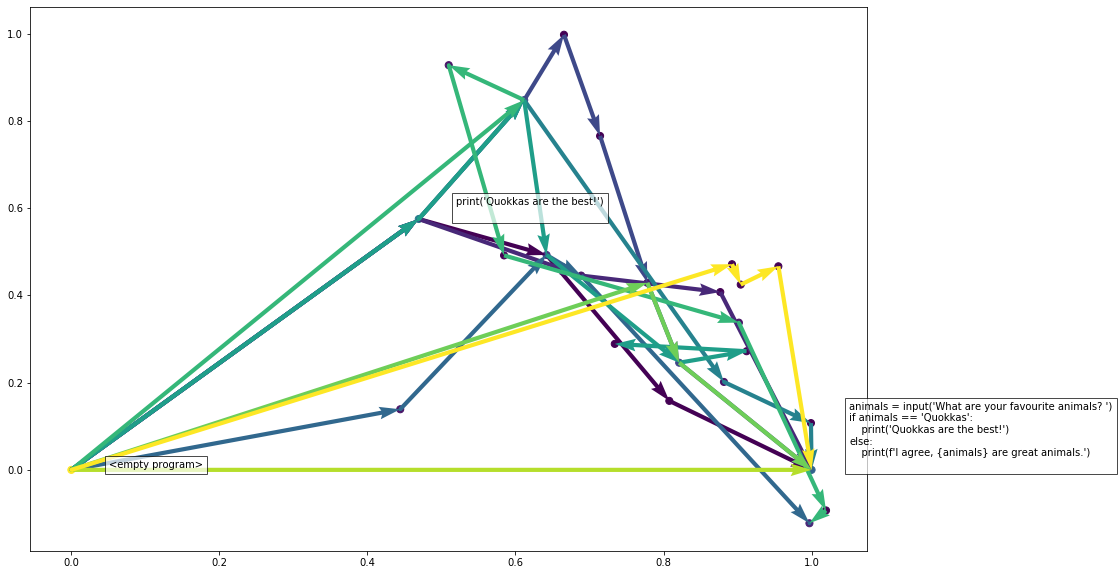

In [9]:
tree_traces = [[0] + [programs_to_trees[program] for program in trace] for trace in traces]

import matplotlib.pyplot as plt
plt.figure(figsize = (15, 10))
ast2vec.traces_plot(start = 0, target = tree_index, traces = tree_traces, X = X, trees = trees, plot_code = 3)

As we can see, student movement can be erratic in this view, but is not entirely random, either. Movement tends to be in the direction of the correct solution, sometimes more directly and sometimes with more curves.

### Prediction using a linear dynamical system

As a final element of our analysis here, we construct a linear dynamical system that pulls towards the correct solution of the task while still following as well as possible how students actually moved.

In more detail, we wish to find a matrix $W$, such that our prediction of the next step $f(\vec x)$ of a student with current step $\vec x$ is given as:

\begin{equation}
f(\vec x) = \vec x + W \cdot (\vec y - \vec x)
\end{equation}

where $\vec y$ is the encoding of the correct solution. It is obvious to see that this function has a fixed point at the correct solution, i.e. if $f(\vec y) = \vec y$. Additionally, if $W$ is a contractive map, we can guarantee that each prediction will decrease the distance between $\vec x$ and $\vec y$, i.e. will bring the student closer to the correct solution in the encoding space. We can guarantee a contractive map by setting $W$ via a linear regression with high regularization parameter. Refer to the paper for a proof.

The detailed documentation of the construct_dynamical_system function is as follows.

*Parameters*
* y: ndarray of size 256 OR int
        The target vector OR index of the target vector in the X matrix.
* X: ndarray of size m x 256
        The data matrix.
* traces: list
        A list of student traces in terms of indices, i.e. a list of lists,
        where each entry is the index of a tree.
* regul: float (default = 1E-3)
        Some positive real number indicating the regularization strength. For
        high values, W becomes close to the identity matrix scaled with some
        small number.

*Returns*
* W: ndarray of size 256 x 256
        The matrix governing the dynamical system.

The detailed documentation of the dynamical_system_plot function is as follows.

*Parameters*
* W: ndarray of size 256 x 256
        matrix describing the linear dynamical system.
* start_tree: tuple OR int
        The tree where we start the interpolation, represented as a tuple of
        node list and adjacency list. If the X argument is given, this can also
        be just the index of the start data point.
* target_tree: tuple OR int
        The tree where we end the interpolation, represented as a tuple of
        node list and adjacency list. If the X argument is given, this can also
        be just the index of the target data point.
* X: ndarray of size m x 256
        A matrix of reference encodings
* grid_size: int (default = 11)
        The number of regular samples between start and target.
* arrow_scale: float (default = 10.)
        The arrow scaling for the dynamical systems plot. Higher values make
        the arrows shorter, which can be beneficial to make the image easier
        to parse.
* step_size: float (default = 1.)
        If a positive number is given, a trace will be simulated that starts
        at start_tree and then follows the dynamical system using Euler's
        method with the given step size. The trace concludes if it is very
        close to the target_tree or after max_steps.
* max_steps: int (default = 10)
        The maximum number of steps in the simulated trace.
* model: class recursive_tree_grammar_auto_encoder.TreeGrammarAutoEncoder (default = None)
        An instance of the ast2vec model. If given, the trees in the simulated
        trace will be decoded as well.
* max_size: int (default = 100)
        A maximum tree size for decoding to prevent endless loops.
* variable_classifier: class variable_classifier.VariableClassifier (default = None)
        An optional variable classifier to make the printed code more clear.

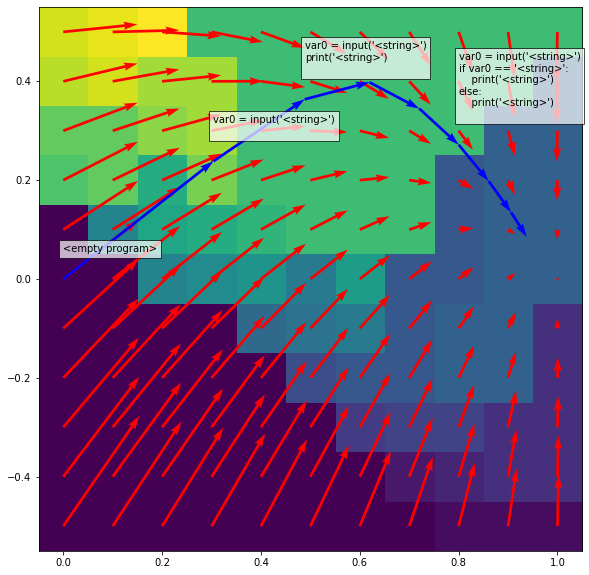

In [10]:
# construct the dynamical system via linear regression
W = ast2vec.construct_dynamical_system(tree_index, X, tree_traces)
# visualize the resulting dynamical system
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 10))
ast2vec.dynamical_system_plot(W, start_tree = 0, target_tree = tree_index, X = X, arrow_scale = 2., model = model, variable_classifier = vc)

### Clustering

For larger data sets, clustering might be more insightful because it summarizes the data. Since ast2vec provides us with points in Euclidean space, we can use any standard clustering mechanism. In this case we infer a Gaussian mixture model using expectation maximization.

In [11]:
# because distances behave strangely in high dimensions and our data set is quite small,
# we do a dimensionality reduction before clustering. For simplicity we use a simple PCA
# at this point and retain 95% of the variance.
from sklearn.decomposition import PCA
dimred = PCA(n_components = 12)
Xlo = dimred.fit_transform(X)
print('our PCA model retains %g percent of the variance' % (100 * np.sum(dimred.explained_variance_ratio_)))

from sklearn.mixture import GaussianMixture
n_clusters = 4
clust = GaussianMixture(n_components = n_clusters, covariance_type = 'diag')
Y = clust.fit_predict(Xlo)
# extract the cluster means and map them back to the high-dimensional space
means = dimred.inverse_transform(clust.means_)

our PCA model retains 95.687 percent of the variance


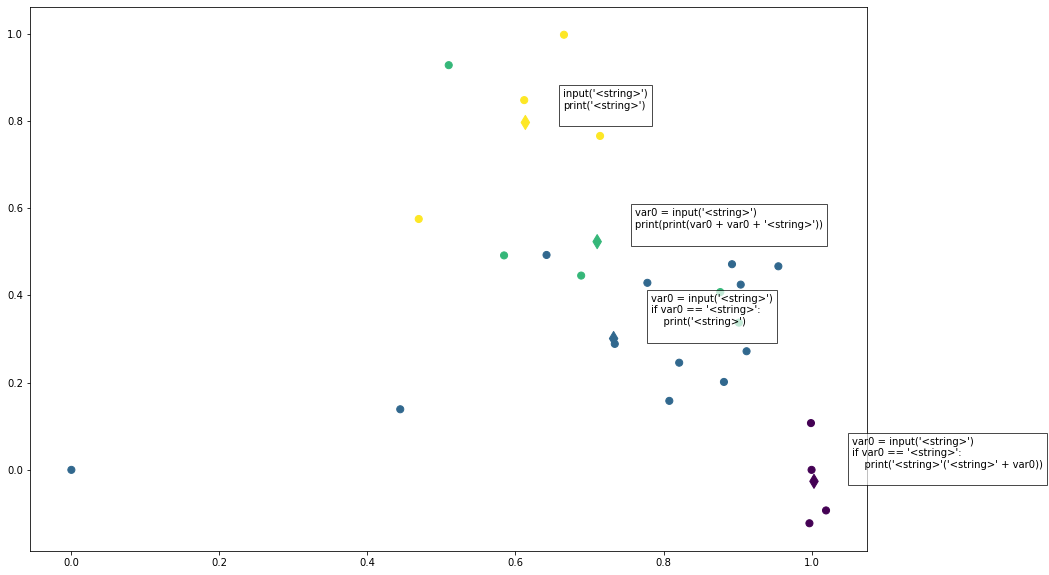

In [12]:
# plot the clustering
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 10))
ast2vec.cluster_plot(start = 0, target = tree_index, X = X, Y = Y, means = means, model = model, variable_classifier = vc)

## Outlier detection

A very simple scheme for outlier detection is to compute the probability assigned to each treee by the model and considering the minimum probability.

In [13]:
import astor
logp = clust.score_samples(Xlo)
# we define outliers as all points with less than half of the average probability score
# assigned to points in the data set
outliers = np.where(logp - np.min(logp) < 0.5 * np.mean(logp - np.min(logp)))[0]
for i in outliers:
    print('next outlier (occurs %d times):' % histogram[i])
    nodes, adj, var = trees[i]
    print(astor.to_source(python_ast_utils.tree_to_ast(nodes, adj, var)))

next outlier (occurs 1 times):

next outlier (occurs 2 times):
animals = input('What are your favourite animals?')

next outlier (occurs 1 times):
animals = input('What are your favourite animals? ')
if animals == 'Koalas':
    print('I agree, Koalas are great animals.')
elif animals == 'Echidnas':
    print('I agree, Echidnas are great animals.')
else:
    print('Quokkas are the best!')

next outlier (occurs 1 times):
print('What are your favourite animals? ')
animals = input
if animals == 'Quokkas':
    print('Quokkas are the best!')
else:
    print(f'I agree, {animals} are great animals.')

next outlier (occurs 1 times):
print('What are your favourite animals? ')
animals = input()
if animals == 'Quokkas':
    print('Quokkas are the best!')
else:
    print(f'I agree, {animals} are great animals.')



One particularly interesting outlier we find here is a 'pseudo-solution' to the task which passes all unit tests but does not live up to the 'spirit' of the task, namely:

```python
animals = input('What are your favourite animals? ')
if animals == 'Koalas':
    print('I agree, Koalas are great animals.')
elif animals == 'Echidnas':
    print('I agree, Echidnas are great animals.')
else:
    print('Quokkas are the best!')
```

With respect to this pseudo-solution we might think about how to change our tests to fail for this case. For example by choosing the input in the last unit test randomly instead using a fixed value. We could also decide that this pseudo-solution is too rare to warrant a change. At any rate, it enables us to inspect the data in more detail.